In [ ]:
import os

# 1. Clone code từ GitHub
repo_url = "https://github.com/MrSalalad/Parallel-programming-final-project"

if not os.path.exists("cuda_project"):
    print(f"Cloning from {repo_url}...")
    !git clone $repo_url cuda_project
else:
    print("Repo đã tồn tại. Đang pull code mới nhất...")
    %cd cuda_project
    !git pull
    %cd ..

# 2. Di chuyển vào thư mục dự án
%cd cuda_project

# 3. Tải & Setup Dataset
if not os.path.exists("data/data_batch_1.bin"):
    print("Downloading & Setting up Data...")
    !mkdir -p data
    !wget -q https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz -O cifar-10-binary.tar.gz
    !tar -xzf cifar-10-binary.tar.gz

    # Di chuyển file từ thư mục con ra ngoài (Flatten) để khớp với code "./data"
    !mv cifar-10-batches-bin/* data/
    !rm -rf cifar-10-batches-bin cifar-10-binary.tar.gz
    print("✅ Data setup complete!")
else:
    print("✅ Data ready.")
!ls -R

Cloning from https://github.com/MrSalalad/Parallel-programming-final-project...
Cloning into 'cuda_project'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 105 (delta 38), reused 50 (delta 17), pack-reused 27 (from 1)
Receiving objects: 100% (105/105), 169.74 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Updating files: 100% (28/28), done.
/content/cuda_project
✅ Data ready.
.:
build_gpu.bat  data	main.cpp     main_gpu_version1.cu  output	 src
build_run.bat  include	main_gpu.cu  Makefile		   Phase2.ipynb

./data:
data_batch_1.bin  data_batch_3.bin  data_batch_5.bin
data_batch_2.bin  data_batch_4.bin  test_batch.bin

./include:
autoencoder.h	   gpu_autoencoder.h  layers.h
cifar10_dataset.h  kernels.cuh	      utils.h

./output:
model_cpu.bin  model_gpu_phase2.bin

./src:
autoencoder.cpp  cifar10_dataset.cpp  gpu  layers.cpp  utils.cpp

./src/gpu:
gpu_autoencoder.cu  ke

In [ ]:
!nvcc -arch=sm_75 -o train_gpu_optimized_memory \
main_gpu_version1.cu \
src/gpu/gpu_autoencoder.cu \
src/gpu/kernels_naive.cu \
src/gpu/kernels_phase3.cu \
src/cifar10_dataset.cpp \
src/autoencoder.cpp \
src/layers.cpp \
-I./include \
-O3

src/gpu/gpu_autoencoder.cu(431): warning #177-D: variable "size_up2" was declared but never referenced
      int size_up2 = batch_size * 256 * 32 * 32;
          ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"



In [ ]:
!./train_gpu_optimized_memory

    PHASE 3: OPTIMIZED GPU TRAINING (Version 1)   
Loading training data...
Initialized 50000 indices for shuffling.
[CONFIG] Target Epochs: 20
[CONFIG] Batch Size   : 64
[INIT] Generating random weights...
Initializing Autoencoder Weights...
[INIT] Booting up GPU...
Allocating GPU Memory (Batch Size: 64)...
GPU Memory Allocated Successfully.
[INFO] Training Started (Optimized)...
Epoch  1/20 | Time: 195.86s | Avg Loss: 0.04501
Epoch  2/20 | Time: 199.36s | Avg Loss: 0.02642
Epoch  3/20 | Time: 199.29s | Avg Loss: 0.02214
Epoch  4/20 | Time: 199.27s | Avg Loss: 0.01991
Epoch  5/20 | Time: 199.25s | Avg Loss: 0.01846
Epoch  6/20 | Time: 199.07s | Avg Loss: 0.01742
Epoch  7/20 | Time: 199.15s | Avg Loss: 0.01661
Epoch  8/20 | Time: 199.00s | Avg Loss: 0.01596
Epoch  9/20 | Time: 199.10s | Avg Loss: 0.01542
Epoch 10/20 | Time: 199.13s | Avg Loss: 0.01497
Epoch 11/20 | Time: 199.04s | Avg Loss: 0.01458
Epoch 12/20 | Time: 199.18s | Avg Loss: 0.01424
Epoch 13/20 | Time: 199.15s | Avg Loss: 

In [ ]:
%%writefile include/utils.h
#ifndef UTILS_H
#define UTILS_H

#include <vector>
#include <string>

// Hàm lưu 1 tấm ảnh (Vector float CHW) ra file BMP để xem
void save_image_bmp(const std::vector<float>& data, int width, int height, int channels, const std::string& filename);

#endif

Overwriting include/utils.h


In [ ]:
%%writefile src/utils.cpp
#include "../include/utils.h"
#include <fstream>
#include <iostream>
#include <vector>
#include <algorithm>
#include <cstdint>

#pragma pack(push, 1)
struct BMPHeader {
    uint16_t file_type{0x4D42}; // "BM"
    uint32_t file_size{0};
    uint16_t reserved1{0};
    uint16_t reserved2{0};
    uint32_t offset_data{0};
};

struct BMPInfoHeader {
    uint32_t size{0};
    int32_t width{0};
    int32_t height{0};
    uint16_t planes{1};
    uint16_t bit_count{0};
    uint32_t compression{0};
    uint32_t size_image{0};
    int32_t x_pixels_per_meter{0};
    int32_t y_pixels_per_meter{0};
    uint32_t colors_used{0};
    uint32_t colors_important{0};
};
#pragma pack(pop)

void save_image_bmp(const std::vector<float>& data, int width, int height, int channels, const std::string& filename) {
    if (channels != 3 && channels != 1) return;

    BMPHeader file_header;
    BMPInfoHeader info_header;

    int row_stride = width * 3;
    int padding_size = (4 - (row_stride % 4)) % 4;
    uint32_t file_size = sizeof(BMPHeader) + sizeof(BMPInfoHeader) + (row_stride + padding_size) * height;

    file_header.file_size = file_size;
    file_header.offset_data = sizeof(BMPHeader) + sizeof(BMPInfoHeader);

    info_header.size = sizeof(BMPInfoHeader);
    info_header.width = width;
    info_header.height = height;
    info_header.bit_count = 24;
    info_header.size_image = (row_stride + padding_size) * height;

    std::ofstream ofs(filename, std::ios::binary);
    if (!ofs) return;

    ofs.write((const char*)&file_header, sizeof(file_header));
    ofs.write((const char*)&info_header, sizeof(info_header));

    std::vector<uint8_t> padding(padding_size, 0);

    for (int y = height - 1; y >= 0; --y) {
        for (int x = 0; x < width; ++x) {
            uint8_t r = 0, g = 0, b = 0;
            if (channels == 3) {
                int idx_r = 0 * (height * width) + y * width + x;
                int idx_g = 1 * (height * width) + y * width + x;
                int idx_b = 2 * (height * width) + y * width + x;
                r = static_cast<uint8_t>(std::max(0.0f, std::min(1.0f, data[idx_r])) * 255);
                g = static_cast<uint8_t>(std::max(0.0f, std::min(1.0f, data[idx_g])) * 255);
                b = static_cast<uint8_t>(std::max(0.0f, std::min(1.0f, data[idx_b])) * 255);
            } else {
                int idx = y * width + x;
                uint8_t val = static_cast<uint8_t>(std::max(0.0f, std::min(1.0f, data[idx])) * 255);
                r = g = b = val;
            }
            ofs.write((const char*)&b, 1);
            ofs.write((const char*)&g, 1);
            ofs.write((const char*)&r, 1);
        }
        if (padding_size > 0) ofs.write((const char*)padding.data(), padding_size);
    }
}

Overwriting src/utils.cpp


In [ ]:
%%writefile src/test_model.cu
#include <iostream>
#include <vector>
#include <fstream>
#include <cuda_runtime.h>
#include <string>

#include "../include/cifar10_dataset.h"
#include "../include/gpu_autoencoder.h"
#include "../include/utils.h"

void load_layer_weight(std::ifstream& file, float* d_data, int size) {
    std::vector<float> h_data(size);
    file.read(reinterpret_cast<char*>(h_data.data()), size * sizeof(float));
    cudaMemcpy(d_data, h_data.data(), size * sizeof(float), cudaMemcpyHostToDevice);
}

void load_trained_model(GPUAutoencoder& model, const std::string& filename) {
    std::ifstream file(filename, std::ios::binary);
    if (!file.is_open()) {
        std::cerr << "❌ Error: File not found: " << filename << std::endl;
        exit(1);
    }
    load_layer_weight(file, model.d_conv1_w, 256*3*3*3);   load_layer_weight(file, model.d_conv1_b, 256);
    load_layer_weight(file, model.d_conv2_w, 128*256*3*3); load_layer_weight(file, model.d_conv2_b, 128);
    load_layer_weight(file, model.d_conv3_w, 128*128*3*3); load_layer_weight(file, model.d_conv3_b, 128);
    load_layer_weight(file, model.d_conv4_w, 256*128*3*3); load_layer_weight(file, model.d_conv4_b, 256);
    load_layer_weight(file, model.d_conv5_w, 3*256*3*3);   load_layer_weight(file, model.d_conv5_b, 3);
    file.close();
}

int main() {
    // 1. Setup
    int batch_size = 5; // Test 5 ảnh
    GPUAutoencoder gpu_model(batch_size);

    // 2. Load Model (File bin bạn vừa train xong)
    load_trained_model(gpu_model, "./output/model_gpu_phase3_ver1.bin");

    // 3. Load Data
    CIFAR10Dataset dataset("./data");
    dataset.load_data();
    std::vector<float> h_batch_data;
    dataset.get_next_batch(batch_size, h_batch_data);

    // 4. Forward GPU
    float* d_input;
    cudaMalloc(&d_input, batch_size * 3 * 32 * 32 * sizeof(float));
    cudaMemcpy(d_input, h_batch_data.data(), batch_size * 3 * 32 * 32 * sizeof(float), cudaMemcpyHostToDevice);
    gpu_model.forward(d_input);

    // 5. Get Result
    std::vector<float> h_output(batch_size * 3 * 32 * 32);
    cudaMemcpy(h_output.data(), gpu_model.d_output, h_output.size() * sizeof(float), cudaMemcpyDeviceToHost);

    // 6. Save BMP
    system("mkdir -p results");
    for (int i = 0; i < batch_size; ++i) {
        std::vector<float> img_in(3 * 32 * 32), img_out(3 * 32 * 32);
        int offset = i * 3 * 32 * 32;
        std::copy(h_batch_data.begin() + offset, h_batch_data.begin() + offset + 3*32*32, img_in.begin());
        std::copy(h_output.begin() + offset, h_output.begin() + offset + 3*32*32, img_out.begin());

        save_image_bmp(img_in, 32, 32, 3, "results/img_" + std::to_string(i) + "_input.bmp");
        save_image_bmp(img_out, 32, 32, 3, "results/img_" + std::to_string(i) + "_out.bmp");
    }
    cudaFree(d_input);
    return 0;
}

Writing src/test_model.cu


In [ ]:
# 1. Biên dịch lại (giờ đã có utils.cpp xịn)
!nvcc -arch=sm_75 -o test_model \
src/test_model.cu \
src/gpu/gpu_autoencoder.cu \
src/gpu/kernels_naive.cu \
src/gpu/kernels_phase3.cu \
src/cifar10_dataset.cpp \
src/utils.cpp \
-I./include \
-O3

# 2. Chạy tạo ảnh
!./test_model

src/test_model.cu(56): warning #1650-D: result of call is not used
      system("mkdir -p results");
      ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

src/test_model.cu(56): warning #1650-D: result of call is not used
      system("mkdir -p results");
      ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

src/test_model.cu: In function ‘int main()’:
src/test_model.cu:56:7: warning: ignoring return value of ‘int system(const char*)’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   56 |     system("mkdir -p results");
      |     ~~^~~~~~~~~~~~~~~~~~~~
src/gpu/gpu_autoencoder.cu(431): warning #177-D: variable "size_up2" was declared but never referenced
      int size_up2 = batch_size * 256 * 32 * 32;
          ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

Allocating GPU Memory (

Đang hiển thị kết quả từ thư mục results/...


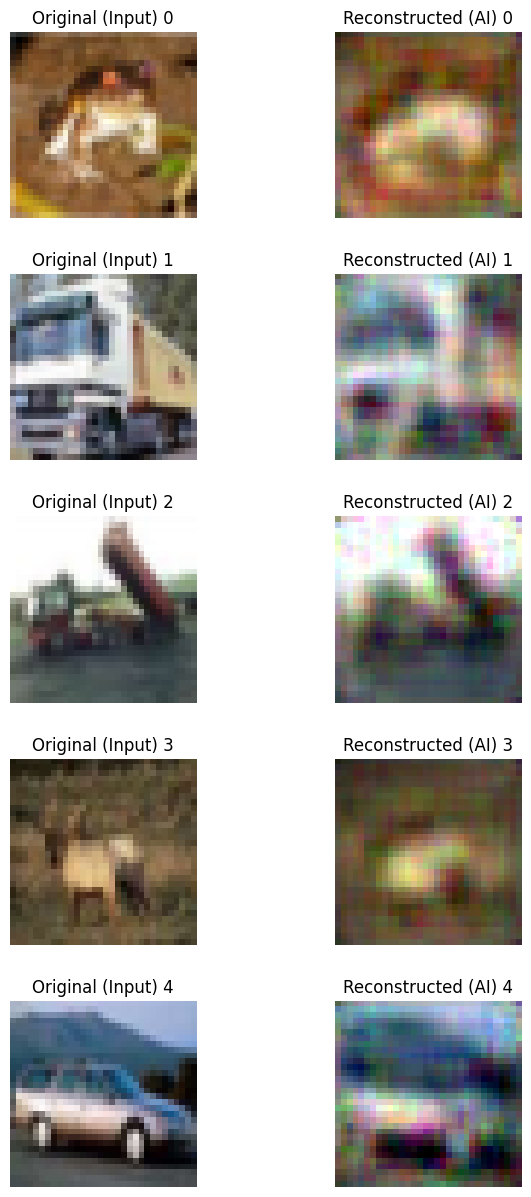

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Cấu hình khung hình
fig, axes = plt.subplots(5, 2, figsize=(8, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

print("Đang hiển thị kết quả từ thư mục results/...")

found_any = False
for i in range(5):
    # Đường dẫn file ảnh
    img_in_path = f"results/img_{i}_input.bmp"
    img_out_path = f"results/img_{i}_out.bmp"

    # Kiểm tra file có tồn tại không
    if os.path.exists(img_in_path) and os.path.exists(img_out_path):
        found_any = True
        img_in = mpimg.imread(img_in_path)
        img_out = mpimg.imread(img_out_path)

        # Cột trái: Ảnh gốc
        axes[i, 0].imshow(img_in)
        axes[i, 0].set_title(f"Original (Input) {i}")
        axes[i, 0].axis('off')

        # Cột phải: Ảnh tái tạo
        axes[i, 1].imshow(img_out)
        axes[i, 1].set_title(f"Reconstructed (AI) {i}")
        axes[i, 1].axis('off')
    else:
        # Nếu chưa chạy xong C++ thì sẽ báo lỗi này
        print(f"❌ Không tìm thấy ảnh số {i}. Bạn đã chạy xong file ./test_model chưa?")

if found_any:
    plt.show()
else:
    print("⚠️ Không có ảnh nào để hiện. Hãy kiểm tra lại bước chạy ./test_model")